In [500]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import lightgbm as lgb

In [501]:
df = pd.read_csv('data/final_combined_dataset.csv')

In [502]:
geocode_list = [3303807]
df = df[df['geocode'].isin(geocode_list)]

In [503]:
df['week'] = pd.to_numeric(df['week'], errors='coerce')
df['date'] = pd.to_datetime(df['date'])

# Add date_ordinal
df['date_ordinal'] = df['date'].apply(lambda x: x.toordinal())

# Extract year and month
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month

# Add cyclic month representation
df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)

# Add cyclic week representation
df['week_sin'] = np.sin(2 * np.pi * df['week'] / 52)
df['week_cos'] = np.cos(2 * np.pi * df['week'] / 52)

In [504]:
# Step 2: Create lag features
def create_lags(dataframe, group_col, target_col, lags):
    if isinstance(target_col, list):  # If target_col is a list of columns
        for col in target_col:
            for lag in lags:
                dataframe[f'{col}_lag{lag}'] = dataframe.groupby(group_col)[col].shift(lag)
    else:  # If target_col is a single column
        for lag in lags:
            dataframe[f'{target_col}_lag{lag}'] = dataframe.groupby(group_col)[target_col].shift(lag)
    return dataframe

# Lag cases by 1 and 2 weeks
data = create_lags(df, group_col='city', target_col='cases', lags=[1, 2])

# Lag weather-related variables by 5 and 6 weeks for each city
weather_columns = ['tempe_min', 'temp_avg', 'temp_max', 'humidity_max', 'humidity_avg', 'humidity_min',
                   'precipitation_avg_ordinary_kriging', 'precipitation_max_ordinary_kriging',
                   'precipitation_avg_regression_kriging', 'precipitation_max_regression_kriging']
data = create_lags(data, group_col='city', target_col=weather_columns, lags=[5, 6])

# data = create_lags(data, group_col='city', target_col='nearby_cases_weighted', lags=[4])

data = data.dropna().reset_index(drop=True)

In [505]:
# Step 4: Scale continuous variables, including lagged variables
feature_scaler = StandardScaler()
target_scaler = StandardScaler()

continuous_vars = ['tempe_min', 'temp_avg', 'temp_max', 'humidity_max', 'humidity_avg', 'humidity_min',
                   'precipitation_avg_ordinary_kriging', 'precipitation_max_ordinary_kriging',
                   'precipitation_avg_regression_kriging', 'precipitation_max_regression_kriging',
                   'cases_per_100k', 'nearby_cases_weighted']
# Include lagged variables in the scaling process
lagged_vars = [col for col in data.columns if any(lag in col for lag in ['_lag1', '_lag2', '_lag5', '_lag6'])]
scaler_vars = continuous_vars + lagged_vars
data[scaler_vars] = feature_scaler.fit_transform(data[scaler_vars])

# Scale the target variable
scaled_cases = target_scaler.fit_transform(data[['cases']])
data['scaled_cases'] = scaled_cases

In [506]:
# Step 5: Split the data into training and testing sets based on time
train_data = data[(data['week'] >= 201201) & (data['week'] <= 202052)]
test_data = data[(data['week'] > 202052)]

columns_exclude = ['date', 'cases', 'scaled_cases', 'city', 'geocode', 'cases_per_100k', 'lat', 'long', 'population', 'year', 'month']

X_train = train_data[[col for col in data.columns if col not in columns_exclude]]
y_train = train_data['scaled_cases']
X_test = test_data[[col for col in data.columns if col not in columns_exclude]]
y_test = test_data['scaled_cases']

In [507]:
# Step 6: Prepare LightGBM datasets
train_dataset = lgb.Dataset(X_train, label=y_train)
test_dataset = lgb.Dataset(X_test, label=y_test, reference=train_dataset)

In [508]:
# Step 7: Define LightGBM parameters
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'learning_rate': 0.05,
    'num_leaves': 31,
    'max_depth': -1,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': -1
}

# Step 8: Train the model with early stopping callback
callbacks = [lgb.early_stopping(stopping_rounds=50), lgb.log_evaluation(period=100)]
model = lgb.train(params, train_dataset, valid_sets=[train_dataset, test_dataset],
                  num_boost_round=1000, callbacks=callbacks)

# Step 9: Make predictions and evaluate
scaled_predictions = model.predict(X_test, num_iteration=model.best_iteration)
# Inverse transform predictions to original scale
y_pred = target_scaler.inverse_transform(scaled_predictions.reshape(-1, 1))

# Step 10: Save the model
model.save_model('lightgbm_dengue_model.txt')

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[27]	training's rmse: 0.560151	valid_1's rmse: 0.310624


Top 10 Most Important Features:
                                    Feature  Importance
19                               cases_lag1          74
13                    nearby_cases_weighted          16
20                               cases_lag2          13
35  precipitation_max_ordinary_kriging_lag5          11
33  precipitation_avg_ordinary_kriging_lag5          11
21                           tempe_min_lag5          11
9        precipitation_avg_ordinary_kriging          11
17                                 week_sin          11
27                        humidity_max_lag5           9
24                            temp_avg_lag6           9


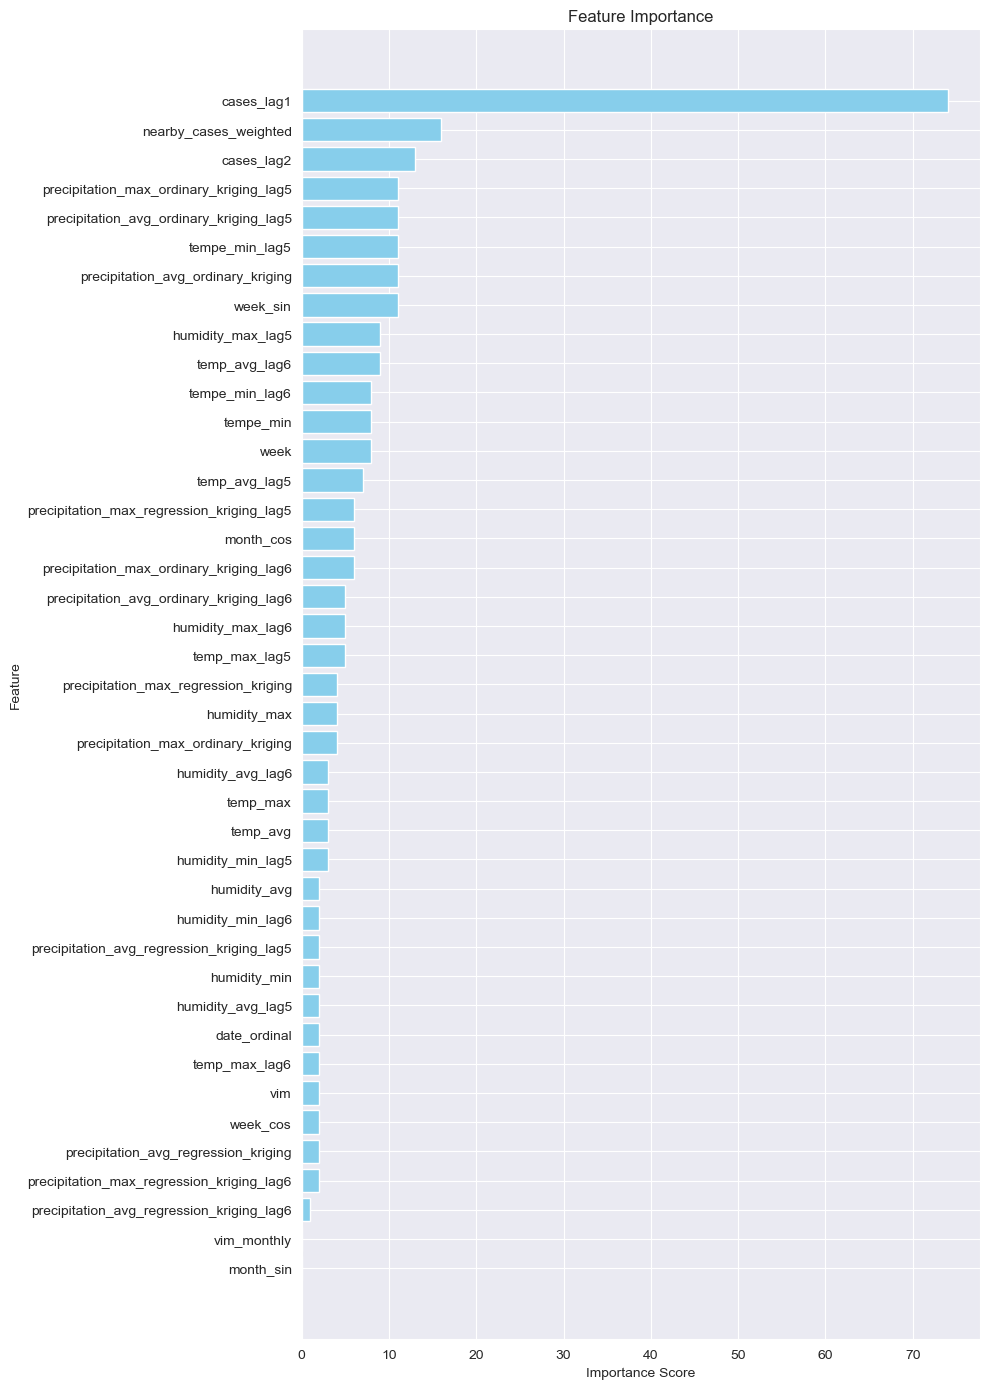

In [509]:
import pandas as pd
import matplotlib.pyplot as plt

# Create a DataFrame for feature importance
importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': model.feature_importance()
})

# Sort by importance
importance = importance.sort_values(by='Importance', ascending=False)

# Print top features in a neat table
print("Top 10 Most Important Features:")
print(importance.head(10))

# Visualize feature importance
plt.figure(figsize=(10, 14))
plt.barh(importance['Feature'], importance['Importance'], color='skyblue')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.gca().invert_yaxis()  # Invert y-axis to show the highest importance at the top
plt.tight_layout()
plt.show()


RMSE: 4.432195953122434


C:\Users\ASUS\miniconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


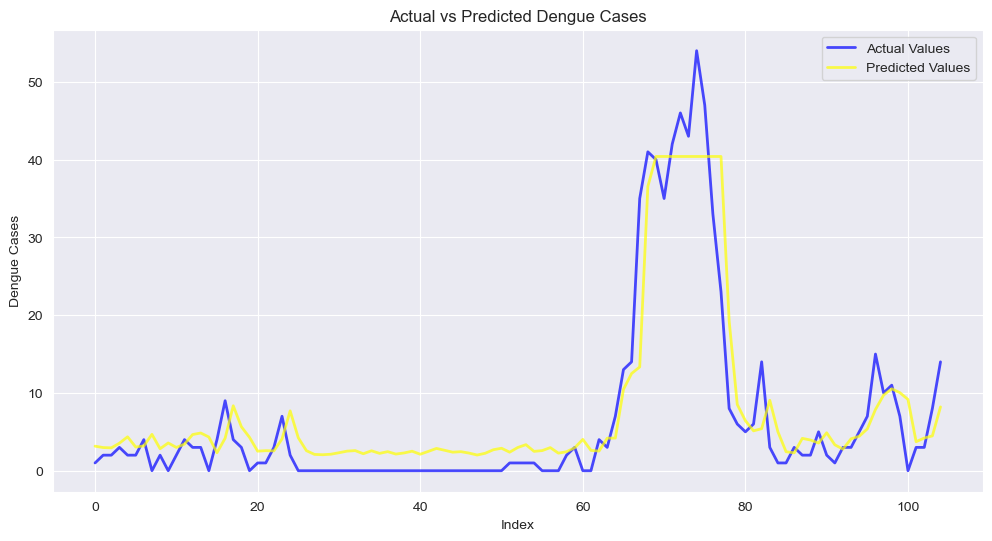

In [510]:
from sklearn.metrics import mean_squared_error

# Step 1: Reshape the actual target values to match the shape of predictions
y_actual = target_scaler.inverse_transform(y_test.values.reshape(-1, 1))
rmse = mean_squared_error(y_actual, y_pred, squared=False)
print(f'RMSE: {rmse}')

# Step 2: Plot the graph
plt.figure(figsize=(12, 6))
plt.plot(np.arange(len(y_actual)), y_actual, label='Actual Values', color='blue', alpha=0.7, linewidth=2)
plt.plot(np.arange(len(y_pred)), y_pred, label='Predicted Values', color='yellow', alpha=0.7, linewidth=2)
plt.xlabel('Index')
plt.ylabel('Dengue Cases')
plt.title('Actual vs Predicted Dengue Cases')
plt.legend()
plt.grid(True)
plt.show()